In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
assert tf.__version__ >= "2.0"


# **Validation accuracy of 89% while hyper parameter tuning and 86.3% when used on actual test set **

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np 
import keras_tuner as kt
import pandas as pd

fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_train_full = X_train_full.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42 , test_size = 0.3)


In [ ]:
import keras_tuner as kt
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    for i in range(1, hp.Int("num_layers", 2, 4)):
        model.add(keras.layers.Dense(units=hp.Int("layer_"+str(i)+"_neurons" , min_value=32, max_value=512, step=32) , activation="relu", kernel_initializer="HeNormal"))

    model.add(keras.layers.Dropout(rate=0.02))
    model.add(keras.layers.Dense(units=10, activation="softmax"))
    learning_rates = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = learning_rates),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=10, factor=3 ,directory='my_dir', project_name='hw_ix')


tuner.search(X_train, y_train , epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 30 Complete [00h 01m 36s]
val_accuracy: 0.8893749713897705

Best val_accuracy So Far: 0.89041668176651
Total elapsed time: 00h 15m 19s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_valid, y_valid, epochs=25, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

model.summary()

Epoch 1/25
450/450 [==============================] - 3s 6ms/step - loss: 0.6196 - accuracy: 0.7813 - val_loss: 0.4582 - val_accuracy: 0.8450
Epoch 2/25
450/450 [==============================] - 2s 5ms/step - loss: 0.4413 - accuracy: 0.8414 - val_loss: 0.4435 - val_accuracy: 0.8522
Epoch 3/25
450/450 [==============================] - 2s 5ms/step - loss: 0.3925 - accuracy: 0.8557 - val_loss: 0.4086 - val_accuracy: 0.8569
Epoch 4/25
450/450 [==============================] - 2s 5ms/step - loss: 0.3546 - accuracy: 0.8714 - val_loss: 0.3745 - val_accuracy: 0.8650
Epoch 5/25
450/450 [==============================] - 2s 5ms/step - loss: 0.3330 - accuracy: 0.8759 - val_loss: 0.3753 - val_accuracy: 0.8725
Epoch 6/25
450/450 [==============================] - 3s 7ms/step - loss: 0.3130 - accuracy: 0.8835 - val_loss: 0.3602 - val_accuracy: 0.8747
Epoch 7/25
450/450 [==============================] - 3s 6ms/step - loss: 0.2960 - accuracy: 0.8890 - val_loss: 0.3688 - val_accuracy: 0.8708
Epoch 

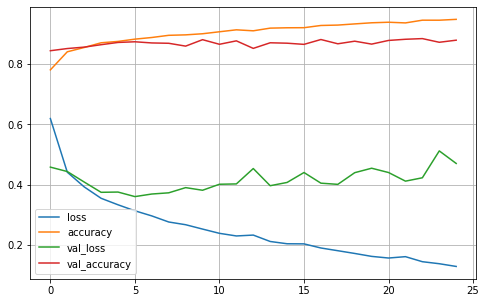

313/313 [==============================] - 1s 3ms/step - loss: 0.5432 - accuracy: 0.8631
Test loss: 0.543236494064331
Test accuracy: 0.863099992275238


In [ ]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()
	
model_score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', model_score[0])
print('Test accuracy:', model_score[1])